In [3]:
from copilot.leakage.leakage_detector import detect_duplicate_and_id_leakage
from copilot.leakage.leakage_detector import detect_train_test_overlap
import pandas as pd
from copilot.auditor.audit_orchestrator import AuditOrchestrator
cur_df = pd.read_csv("/Users/tobyliu/model_audit_copilot/data/cur_df.csv")
ref_df = pd.read_csv("/Users/tobyliu/model_audit_copilot/data/ref_df.csv")
auditor = AuditOrchestrator(ref_df, cur_df)
auditor.run_leakage_check(dataset=cur_df, target_col="true_cost")
leakage = auditor.get_leakage_report()
print(leakage["target_leakage"])
print(leakage["duplicate_rows"])
print(leakage["train_test_overlap"])

          feature  correlation  leakage_flag
0  predicted_cost       0.9263          True
0
{'train_size': 1000, 'test_size': 1000, 'overlap_count': 0, 'percent_overlap': 0.0}


In [4]:
from copilot.schema.schema_validator import compare_schemas, find_missing_or_extra_columns

schema_report = compare_schemas(ref_df, cur_df)
column_diff = find_missing_or_extra_columns(ref_df, cur_df)

print(schema_report)
print(column_diff)


           column reference_type current_type  mismatch
0             age        float64      float64     False
1          income        float64      float64     False
2  predicted_cost        float64      float64     False
3            race         object       object     False
4       true_cost        float64      float64     False
{'missing_in_current': [], 'extra_in_current': []}


In [5]:
from copilot.auditor.audit_orchestrator import AuditOrchestrator

# Initialize orchestrator
auditor = AuditOrchestrator(ref_df, cur_df)

# Run schema check
auditor.run_schema_check()

# Retrieve and print results
schema = auditor.get_schema_report()

print("\nSchema Comparison:")
print(schema["schema_comparison"])

print("\nMissing / Extra Columns:")
print(schema["column_diff"])


Schema Comparison:
           column reference_type current_type  mismatch
0             age        float64      float64     False
1          income        float64      float64     False
2  predicted_cost        float64      float64     False
3            race         object       object     False
4       true_cost        float64      float64     False

Missing / Extra Columns:
{'missing_in_current': [], 'extra_in_current': []}


/var/folders/9p/ldmwxfsd7kg410hw4z5tm2km0000gn/T/ipykernel_28981/1394447721.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


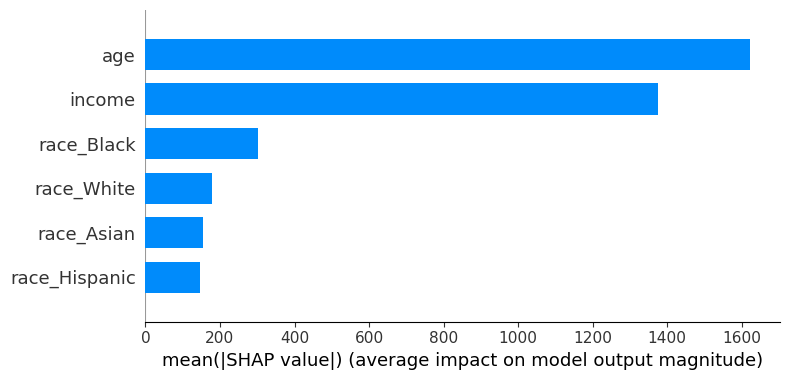

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from copilot.explainability.shap_explainer import compute_shap_summary

# Load and encode data
df = pd.read_csv("/Users/tobyliu/model_audit_copilot/data/cur_df.csv")
X_raw = df.drop(columns=["true_cost", "predicted_cost"])
X = pd.get_dummies(X_raw).astype(float)  # Ensure all features are numeric
y = df["true_cost"]

# Split and train
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor().fit(X_train, y_train)

# Compute SHAP summary
fig = compute_shap_summary(model, X_train)
fig.show()


/var/folders/9p/ldmwxfsd7kg410hw4z5tm2km0000gn/T/ipykernel_30035/2700572987.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


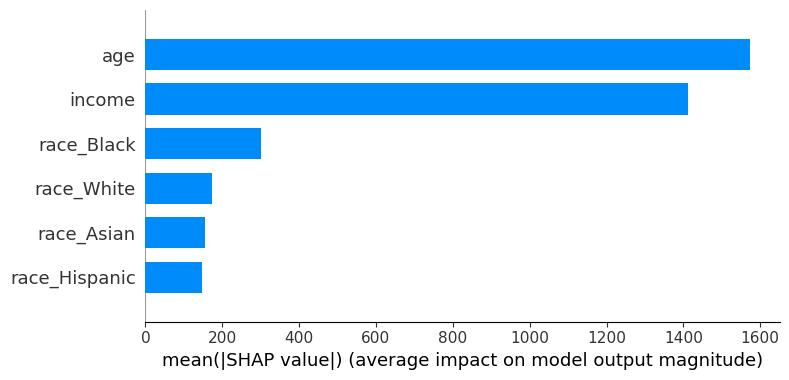

In [2]:
from copilot.auditor.audit_orchestrator import AuditOrchestrator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("/Users/tobyliu/model_audit_copilot/data/cur_df.csv")
X = pd.get_dummies(df.drop(columns=["true_cost", "predicted_cost"])).astype(float)
y = df["true_cost"]

X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor().fit(X_train, y_train)

auditor = AuditOrchestrator(None, None)
auditor.run_explainability(model, X_train)

fig = auditor.get_shap_plot()
fig.show()


In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pickle

# Load data
df = pd.read_csv("/Users/tobyliu/model_audit_copilot/data/cur_df.csv")

# Drop target and prediction columns
X = pd.get_dummies(df.drop(columns=["true_cost", "predicted_cost"])).astype(float)
y = df["true_cost"]

# Train model
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor().fit(X_train, y_train)

# Save the model to a file
with open("rf_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the corresponding features
X_train.to_csv("shap_input.csv", index=False)


In [1]:
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from copilot.explainability.shap_comparator import compare_shap_importance

# Load and prepare data
df = pd.read_csv("/Users/tobyliu/model_audit_copilot/data/cur_df.csv")
X = pd.get_dummies(df.drop(columns=["true_cost", "predicted_cost"])).astype(float)
y = df["true_cost"]
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

# Train two slightly different models
model_a = RandomForestRegressor(n_estimators=50).fit(X_train, y_train)
model_b = RandomForestRegressor(n_estimators=150).fit(X_train, y_train)

# Compare their SHAP importances
shap_comparison = compare_shap_importance(model_a, model_b, X_train)
print(shap_comparison)


/opt/anaconda3/envs/ml-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 98%|===================| 788/800 [00:14<00:00]        

         feature  mean_abs_shap_a  mean_abs_shap_b      delta
0     race_White       152.058774       204.808334  52.749560
1            age      1593.063754      1588.695138  -4.368616
2     race_Asian       164.842587       157.266595  -7.575991
3     race_Black       279.076315       265.103353 -13.972962
4  race_Hispanic       176.012864       143.585625 -32.427239
5         income      1470.444530      1398.929493 -71.515037


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap

# Load your dataset
df = pd.read_csv("/Users/tobyliu/model_audit_copilot/data/cur_df.csv")
X = pd.get_dummies(df.drop(columns=["true_cost", "predicted_cost"])).astype(float)
y = df["true_cost"]

# Split train data
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

# Train two slightly different models
model_a = RandomForestRegressor(n_estimators=50, random_state=1).fit(X_train, y_train)
model_b = RandomForestRegressor(n_estimators=150, max_depth=8, random_state=2).fit(X_train, y_train)

# Use TreeExplainer ONLY (avoids Torch/CUDA issues)
explainer_a = shap.TreeExplainer(model_a)
shap_values_a = explainer_a.shap_values(X_train)
mean_shap_a = pd.DataFrame({
    "feature": X_train.columns,
    "mean_abs_shap": pd.DataFrame(shap_values_a).abs().mean().values
}).sort_values(by="mean_abs_shap", ascending=False)

explainer_b = shap.TreeExplainer(model_b)
shap_values_b = explainer_b.shap_values(X_train)
mean_shap_b = pd.DataFrame({
    "feature": X_train.columns,
    "mean_abs_shap": pd.DataFrame(shap_values_b).abs().mean().values
}).sort_values(by="mean_abs_shap", ascending=False)

# Save both to CSV
mean_shap_a.to_csv("shap_model_a.csv", index=False)
mean_shap_b.to_csv("shap_model_b.csv", index=False)


In [1]:
%load_ext sql
%sql sqlite:///data/hospital_audit.db

'Connected: @data/hospital_audit.db'

In [2]:
%%sql
SELECT * FROM hospital_costs LIMIT 5;

 * sqlite:///data/hospital_audit.db
Done.


age,income,race,true_cost,predicted_cost
49.86510315022302,52925.72720139101,Asian,28211.59001723726,27746.308077021906
37.00911752674645,53344.07719953892,Black,21052.73065579243,24090.782885328194
57.59495796646783,39300.48852040526,White,21347.18428456054,22117.14408637361
24.637236902370976,59228.392683526195,Black,19406.444200425532,26423.592108299956
31.4899292623128,54156.64766415098,Black,25106.702865818566,26090.218783792858
